In [8]:
import pickle as pkl
import numpy as np
from envs.env_helper import *
import argparse
import os
from main import ENV_CONFIG
import torch
from agent.rfsac.rfsac_agent import RFVCritic, nystromVCritic
from gymnasium.wrappers.record_video import RecordVideo
from agent.rfsac import rfsac_agent
from agent.sac import sac_agent
from agent.sac.actor import DiagGaussianActor
from utils.util import eval_policy, visualize_policy, get_theta_traj

def eval(log_path, ):
    with open(os.path.join(log_path, 'train_params.pkl'), 'rb') as f:        
        kwargs = pkl.load(f)
    env_name = kwargs['env']
    
    eval_config = ENV_CONFIG.copy()
    eval_config.update({'reward_scale': 0.3,
                        'eval': True,
                        'reward_exponential': False,
                        'reward_type': 'energy',
                        'noise_scale': kwargs['sigma']})
    
    if env_name == "Pendulum-v1":
        env = gymnasium.make('Pendulum-v1', render_mode='human')
        eval_env = RescaleAction(env, min_action=-1., max_action=1.)
        # eval_env = RecordVideo(eval_env, video_folder=log_path)
    elif env_name == 'Quadrotor2D-v2':
        eval_env = env_creator_quad2d(eval_config)
    elif env_name == 'Pendubot-v0':
        eval_env = env_creator_pendubot(eval_config)
    elif env_name == 'CartPoleContinuous-v0':
        eval_env = env_creator_cartpole(eval_config)
    elif env_name == 'CartPendulum-v0':
        eval_env = env_creator_cartpendulum(eval_config)
    kwargs['action_space'] = eval_env.action_space

    use_nystrom = kwargs['use_nystrom']

    actor = DiagGaussianActor(obs_dim=kwargs['obs_space_dim'][0],
                              action_dim=kwargs['action_dim'],
                              hidden_dim=kwargs['hidden_dim'],
                              hidden_depth=2,
                              log_std_bounds=[-5., 2.])

    actor.load_state_dict(torch.load(log_path+"/actor_last.pth"))
    # critic.load_state_dict(torch.load(log_path + "/critic.pth"))
    agent = rfsac_agent.DensityConstrainedLagrangianAgent(**kwargs)
    agent.actor = actor
    agent.device = torch.device("cpu")

    thetas = get_theta_traj(agent, eval_env)

    return thetas

In [15]:
thetas = eval('/home/mht/PycharmProjects/lvrep-rl-cloned/log/Pendulum-v1_sigma_0.0_rew_scale_1.0/density_nystrom_False_rf_num_512_learn_rf_False/try_evaluate_density/0/')

In [16]:
np.save('swingup_cstr.npy',thetas)

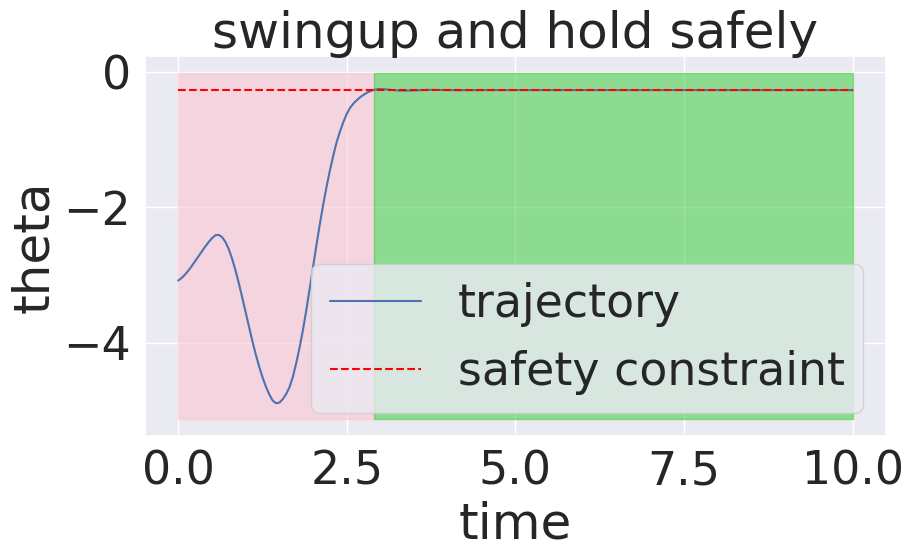

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
fig, ax = plt.subplots(figsize=[10,6])
sns.set(font_scale=3)
thetas = np.load('swingup_cstr.npy')
thetas = np.where(thetas<-1 * np.ones_like(thetas),thetas + 2 * np.pi*np.ones_like(thetas), thetas)
data = pd.DataFrame.from_dict({'time':np.arange(0, 10.05, 0.05), 'theta':thetas})
# sns.lineplot(data, x='time', y='theta')
plt.plot(np.arange(0, 10.05, 0.05),-1 * thetas, label='trajectory')
plt.xlabel('time')
plt.ylabel('theta')
plt.plot(np.arange(0, 10.05, 0.05), -0.275 * np.ones_like(thetas), linestyle='--', color='red', label='safety constraint')
ymin, ymax = ax.get_ylim()
# inter = 
plt.fill_between((0, 2.9), ymin, ymax,alpha=0.5, color='pink')
plt.fill_between((2.9, 10), ymin, ymax,alpha=0.5, color='limegreen')
# sns.set_style('')
plt.legend()
plt.tight_layout()
plt.title('swingup and hold safely')
plt.savefig('safe.pdf')


In [40]:
np.where(thetas < 0.275)

(array([ 58,  59,  60,  61,  62,  63,  64,  65,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
        167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
        193, 194, 195, 196, 197, 198, 199, 200]),)

In [9]:
len(np.arange(0, 10, 0.05))

200

In [26]:
import torch

dist = torch.distributions.uniform.Uniform(0, 1)

In [31]:
dist.log_prob(torch.tensor(-1.0))

ValueError: Expected value argument (Tensor of shape ()) to be within the support (Interval(lower_bound=0.0, upper_bound=1.0)) of the distribution Uniform(low: 0.0, high: 1.0), but found invalid values:
-1.0